<a href="https://colab.research.google.com/github/Data-Creater-Atlas/Data-Atlas/blob/yejun/mission1_0922.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# ultralytics는 YOLOv8을 사용하기 위한 핵심 라이브러리입니다.
!pip install ultralytics matplotlib -q

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 39.0 MB/s eta 0:00:00


In [ ]:
''' 1. Module Import '''
import torch
from ultralytics import YOLO
import os
import matplotlib.pyplot as plt
from IPython.display import Image

# Google Drive에 프로젝트 폴더를 생성하고 경로를 지정합니다.
# 이렇게 하면 결과가 내 드라이브에 저장됩니다.
GDRIVE_PROJECT_PATH = "/content/my_data_code"
if not os.path.exists(GDRIVE_PROJECT_PATH):
    os.makedirs(GDRIVE_PROJECT_PATH)

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


In [ ]:
''' 2. 딥러닝 모델을 설계할 때 활용하는 장비 확인 '''
if torch.cuda.is_available():
    DEVICE = torch.device('cuda')
    print('Using PyTorch version:', torch.__version__, ' Device:', DEVICE)
    print('CUDA is available. Using GPU for training.')
else:
    DEVICE = torch.device('cpu')
    print('Using PyTorch version:', torch.__version__, ' Device:', DEVICE)
    print('CUDA is not available. Using CPU for training.')

NameError: name 'torch' is not defined

# 데이터 루트 지정

In [ ]:
DATA_ROOT = "/content/drive/MyDrive/Colab Notebooks/data_project1"

import os, pathlib
pathlib.Path(DATA_ROOT).mkdir(parents=True, exist_ok=True)
print("DATA_ROOT : ", DATA_ROOT)

DATA_ROOT :  /content/drive/MyDrive/Colab Notebooks/data_project1


# 학습 및 테스트 파일 경로 / 폴더 지정

In [ ]:
from pathlib import Path

# 원본 데이터( 이미지 / 라벨 JSON )
TS_DIR = Path(DATA_ROOT) / "images"  / "TS_KS"
TL_JSON_DIR = Path(DATA_ROOT) / "labels"  / "TL_KS_BBOX"
VS_DIR = Path(DATA_ROOT) / "images"  / "VS_KS"
VL_JSON_DIR = Path(DATA_ROOT) / "labels" / "VL_KS_BBOX"

# YOLO 데이터셋 출력 위치
DATASET_DIR = Path(DATA_ROOT) / "YOLO_Dataset"
(TR_IMG_DIR := DATASET_DIR/"train/images").mkdir(parents=True, exist_ok=True)
(TR_LABEL_DIR := DATASET_DIR/"train/labels").mkdir(parents=True, exist_ok=True)
(VAL_IMG_DIR := DATASET_DIR/"valid/images").mkdir(parents=True, exist_ok=True)
(VAL_LABEL_DIR := DATASET_DIR/"valid/labels").mkdir(parents=True, exist_ok=True)

CLASS_NAMES = ["chimney"]

# VIA JSON -> YOLO 변환 + 이미지 복사

In [ ]:
import json, shutil
from tqdm import tqdm

# VIA JSON 내부 값이 문자열 / 숫자 혼재일 수 있어 안전하게 float로 변환
def _ensure_float(v):
  try:
    return float(v)
  except:
    return float(str(v).strip())

# 파라미터 변수
# 1. json_path : VIA JSON 파일 경로
# 2. images_dir : 원본 이미지 폴더 경로
# 3. out_img_dir : 변환된 이미지를 저장할 폴더 경로 (YOLO용 학습/검증 이미지 폴더)
# 4. out_lbl_dir : 변환된 라벨을 저장할 폴더 경로 (YOLO용 라벨 저장 폴더)
# 5. class_id : 단일 클래스일 경우 0으로 고정

def via_json_to_yolo(json_path: Path, images_dir: Path, out_img_dir: Path, out_lbl_dir: Path, class_id:int = 0):
  with open(json_path, "r", encoding="utf-8") as f:
        data = json.load(f)

  for key, item in data.items():
        #이미지 파일명
        # 최상단 키가 파일명이므로 filename 필드를 키값으로 사용
        img_name = item.get("filename") or key
        # 확장자를 분리했다가 다시 붙여서 정규화
        if "." in img_name:
          stem, ext = img_name.rsplit(".", 1)
          img_name = stem + "." + ext

        # 원본 이미지 파일 찾기 - images_dir에서 해당 파일을 찾음
        src_img = images_dir / img_name


        if not src_img.exists():
          cands = list(images_dir.glob(Path(img_name).stem + ".*"))
          # 동일한 파일명이 없으면 동일 stem으로 후보를 찾아 첫 번째 매칭 사용
          if cands:
            src_img = cands[0]
          # 그래도 없으면 해당 이미지 및 라벨은 스킵
          else:
            continue

        # 이미지 크기 - file_attributes에서 이미지 폭/높이를 읽음
        fa = item.get("file_attributes", {})
        W = int(_ensure_float(fa.get("img_width", 0)))
        H = int(_ensure_float(fa.get("img_height", 0)))
        # 혹시라도 0이면 변환 불가로 스킵
        if W == 0 or H == 0:
          continue

        lines = []
        # 이미지 내 라벨(regions)을 순회
        for region in item.get("regions", []):
          sa = region.get("shape_attributes", {})
          name = sa.get("name", "")
          # 사각형 라벨은 x,y,width, height 그래로 사용
          if name == "rect":
            x = _ensure_float(sa["x"]); y = _ensure_float(sa["y"])
            bw = _ensure_float(sa["width"]); bh = _ensure_float(sa["height"])

          # 폴리라인 라벨은 바운딩 박스로 감싼 뒤(x, y , w, h)로 변환
          elif name == "polyline":
            xs = sa.get("all_points_x", []); ys = sa.get("all_points_y", [])
            if not xs or not ys:
              continue
            min_x, max_x = min(xs), max(xs)
            min_y, max_y = min(ys), max(ys)
            x, y = _ensure_float(min_x), _ensure_float(min_y)
            bw = _ensure_float(max_x - min_x)
            bh = _ensure_float(max_y - min_y)
          # 기타 라벨은 스킵
          else:
            continue

          #YOLO 정규화 (cx, cy, w, h) - Yolo 포맷은 정규화된 중심 좌표/폭/높이: (cx, cy, w, h)
          cx = (x + bw/2) / W; cy = (y + bh/2) / H
          nw = bw / W;         nh = bh / H
          #범위 보정 - 값들을 0 ~ 1 범위로 보정
          cx = max(0, min(1, cx)); cy = max(0, min(1, cy))
          nw = max(0, min(1, nw)); nh = max(0, min(1, nh))
          # 0 이하 레벨은 스킵
          if nw <= 0 or nh <= 0:
            continue

          # 최종적으로 한 객체당 "class cx cy w h" 라인을 만들고 lines 리스트 추가
          lines.append(f"{class_id} {cx:.6f} {cy:.6f} {nw:.6f} {nh:.6f}")

        #라벨 저장 + 이미지 복사
        # 변화된 라벨이 하나라도 있으면 labels/파일명.txt로 저장
        # 해당 이미지 파일을 YOLO 폴더로 복사
        if lines:
          out_lbl = out_lbl_dir / f"{Path(img_name).stem}.txt"
          out_lbl.write_text("\n".join(lines), encoding = "utf-8")
          dst_img = out_img_dir / src_img.name
          if not dst_img.exists():
            shutil.copy2(src_img, dst_img)

# Train/Val 전체 변환
# 학습용 JSON과 검증용 JSON 폴더를 각각 순회하며 변환을 수행
# 진행사항을 tqdm으로 표시
for jp in tqdm(sorted(TL_JSON_DIR.glob("*.json")), desc = "train json -> yolo"):
  via_json_to_yolo(jp, TS_DIR, TR_IMG_DIR, TR_LABEL_DIR, class_id = 0)

for jp in tqdm(sorted(VL_JSON_DIR.glob("*.json")), desc="val json→yolo"):
    via_json_to_yolo(jp, VS_DIR, VAL_IMG_DIR, VAL_LABEL_DIR, class_id=0)


# 변환 결과로 생성된 이미지/라벨 개수를 요약
print("train images:", len(list(TR_IMG_DIR.glob("*"))))
print("train labels:", len(list(TR_LABEL_DIR.glob("*.txt"))))
print("val images:", len(list(VAL_IMG_DIR.glob("*"))))
print("val labels:", len(list(VAL_LABEL_DIR.glob("*.txt"))))


val json→yolo: 100%|██████████| 1006/1006 [10:44<00:00,  1.56it/s]


train images: 8052
train labels: 8052
val images: 1006
val labels: 1006


In [ ]:
data_yaml = f"""
train: {str(TR_IMG_DIR)}
val: {str(VAL_IMG_DIR)}

nc: {len(CLASS_NAMES)}
names: {CLASS_NAMES}
""".strip()

(DATASET_DIR / "data.yaml").write_text(data_yaml, encoding="utf-8")
print((DATASET_DIR /"data.yaml").read_text())

train: /content/drive/MyDrive/Colab Notebooks/data_project1/YOLO_Dataset/train/images
val: /content/drive/MyDrive/Colab Notebooks/data_project1/YOLO_Dataset/valid/images

nc: 1
names: ['chimney']


#학습 실행(YOLOv8)

In [ ]:
from ultralytics import YOLO

# 가볍게 검증
model = YOLO("yolov8n.pt")

results = model.train(
    data=str(DATASET_DIR/"data.yaml"),
    epochs=60, # epochs 60회 반복
    imgsz=512, # 이미지 사이즈 512
    batch=16, # 배치 사이즈 16
    patience=20, # 20 epoch동안 개선 X -> 조기 종료
    project=str(Path(DATA_ROOT)/"runs/chimney_detection"),
    name="yolov8n_exp1",
    verbose=True
)

Ultralytics 8.3.199 🚀 Python-3.12.11 torch-2.8.0+cu126 CUDA:0 (NVIDIA A100-SXM4-80GB, 81222MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/content/drive/MyDrive/Colab Notebooks/data_project1/YOLO_Dataset/data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=60, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=512, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolov8n.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=yolov8n_exp14, nbs=64, nms=False, opset=None, optimize=False, optimizer=auto, 

# 데이터 검증

In [ ]:


from ultralytics import YOLO

# 가볍게 검증 → 성능 필요 시 yolov8s.pt / yolov8m.pt 로 교체
model = YOLO("yolov8n.pt")

In [ ]:
_ = model.val(data=str(DATASET_DIR/"data.yaml"), imgsz=512)

# 검증 이미지들에 대한 예측결과(시각화) 저장
pred = model.predict(
    source=str(VAL_IMG_DIR),
    conf=0.25,
    save=True,
    imgsz=512,
    project=str(Path(DATA_ROOT)/"runs/chimney_detection"),
    name="yolov8n_exp1_pred"
)

Ultralytics 8.3.199 🚀 Python-3.12.11 torch-2.8.0+cu126 CUDA:0 (NVIDIA A100-SXM4-80GB, 81222MiB)
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs
val: Fast image access ✅ (ping: 1.0±0.8 ms, read: 0.2±0.1 MB/s, size: 105.3 KB)
val: Scanning /content/drive/MyDrive/Colab Notebooks/data_project1/YOLO_Dataset/valid/labels.cache... 1006 images, 0 backgrounds, 0 corrupt: 100% ━━━━━━━━━━━━ 1006/1006 957.7Kit/s 0.0s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 63/63 1.6it/s 39.2s
                   all       1006       1322    0.00486    0.00454     0.0018   0.000802
                person       1006       1322    0.00486    0.00454     0.0018   0.000802
Speed: 0.2ms preprocess, 0.8ms inference, 0.0ms loss, 1.5ms postprocess per image
Results saved to /content/runs/detect/val

WARNING ⚠️ 
inference results will accumulate in RAM unless `stream=True` is passed, causing potential out-of-memory
errors fo

results.csv: /content/drive/MyDrive/Colab Notebooks/data_project1/runs/chimney_detection/yolov8n_exp14/results.csv


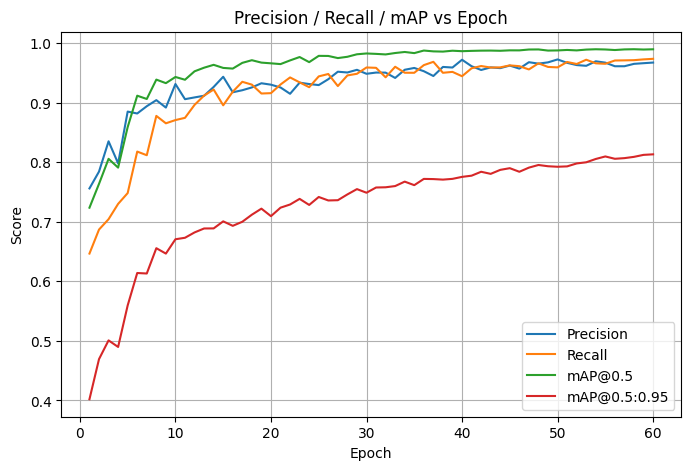

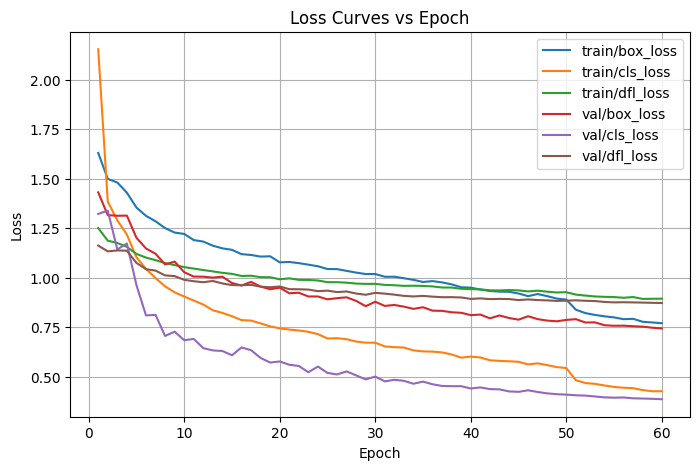

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
import glob

# 최신 train run의 results.csv 찾기
runs_dir = Path(DATA_ROOT)/"runs/chimney_detection"
csv_candidates = sorted(glob.glob(str(runs_dir / "yolov8n_exp1" / "results.csv")))
if not csv_candidates:
    # 폴더명이 조금 바뀐 경우 대비: 가장 최근 results.csv 탐색
    csv_candidates = sorted(glob.glob(str(runs_dir / "**/results.csv"), recursive=True))
assert csv_candidates, "results.csv를 찾을 수 없습니다. 학습 셀 실행 여부를 확인하세요."
csv_path = csv_candidates[-1]
print("results.csv:", csv_path)

df = pd.read_csv(csv_path)

# 컬럼 후보(버전에 따라 차이가 있을 수 있어 안전하게 get)
def col(name, alt=None):
    return name if name in df.columns else (alt if (alt and alt in df.columns) else None)

epoch = df.index + 1  # 0부터 시작하므로 +1

# ==== 6-1) 정밀도/재현율/mAP 그래프 ====
prec_col = col('metrics/precision(B)')
rec_col  = col('metrics/recall(B)')
map50    = col('metrics/mAP50(B)', alt='metrics/mAP50(B)')
map5095  = col('metrics/mAP50-95(B)', alt='metrics/mAP50-95(B)')

plt.figure(figsize=(8,5))
if prec_col: plt.plot(epoch, df[prec_col], label='Precision')
if rec_col:  plt.plot(epoch, df[rec_col],  label='Recall')
if map50:    plt.plot(epoch, df[map50],    label='mAP@0.5')
if map5095:  plt.plot(epoch, df[map5095],  label='mAP@0.5:0.95')
plt.xlabel("Epoch"); plt.ylabel("Score"); plt.title("Precision / Recall / mAP vs Epoch")
plt.grid(True); plt.legend(); plt.show()

# ==== 6-2) 트레이닝/밸리데이션 로스 ====
loss_cols = [c for c in df.columns if "loss" in c]
plt.figure(figsize=(8,5))
for c in loss_cols:
    plt.plot(epoch, df[c], label=c)
plt.xlabel("Epoch"); plt.ylabel("Loss"); plt.title("Loss Curves vs Epoch")
plt.grid(True); plt.legend(); plt.show()

In [ ]:
import pandas as pd
from IPython.display import display

# 주요 지표 후보
cols_to_show = [
    'metrics/precision(B)',
    'metrics/recall(B)',
    'metrics/mAP50(B)',
    'metrics/mAP50-95(B)',
    'metrics/IoU(B)',              # IoU 전체 평균
    'metrics/IoU@0.5(B)',          # IoU=0.5 기준 (버전에 따라 존재)
    'train/box_loss', 'train/obj_loss', 'train/cls_loss',
    'val/box_loss', 'val/obj_loss', 'val/cls_loss'
]

# 실제 results.csv에 존재하는 컬럼만 필터링
valid_cols = [c for c in cols_to_show if c in df.columns]

# 에포크 번호 추가
table = df[valid_cols].copy()
table.insert(0, "epoch", df.index + 1)

# 소수점 둘째 자리까지만 반올림
table_rounded = table.round(3)

# 표 출력 (앞 10 epoch 예시)
display(table_rounded.head(10))

# 마지막 5 epoch만 보고 싶을 때
display(table_rounded.tail(5))


,epoch,metrics/precision(B),metrics/recall(B),metrics/mAP50(B),metrics/mAP50-95(B),train/box_loss,train/cls_loss,val/box_loss,val/cls_loss
0,1,0.756,0.647,0.724,0.402,1.631,2.155,1.432,1.323
1,2,0.784,0.687,0.764,0.469,1.500,1.385,1.317,1.339
2,3,0.835,0.704,0.806,0.501,1.481,1.290,1.313,1.143
3,4,0.798,0.730,0.791,0.490,1.430,1.218,1.314,1.173
4,5,0.885,0.748,0.859,0.559,1.355,1.104,1.202,0.963
5,6,0.882,0.818,0.912,0.614,1.313,1.045,1.148,0.810
6,7,0.894,0.812,0.906,0.613,1.285,0.998,1.121,0.812
7,8,0.904,0.878,0.939,0.656,1.251,0.957,1.067,0.706
8,9,0.892,0.865,0.933,0.646,1.228,0.926,1.082,0.727
9,10,0.931,0.871,0.943,0.671,1.221,0.905,1.028,0.684


,epoch,metrics/precision(B),metrics/recall(B),metrics/mAP50(B),metrics/mAP50-95(B),train/box_loss,train/cls_loss,val/box_loss,val/cls_loss
55,56,0.961,0.971,0.988,0.806,0.791,0.444,0.758,0.395
56,57,0.961,0.971,0.989,0.807,0.792,0.442,0.755,0.390
57,58,0.965,0.971,0.990,0.809,0.777,0.432,0.753,0.389
58,59,0.966,0.973,0.989,0.812,0.774,0.426,0.747,0.388
59,60,0.967,0.974,0.990,0.813,0.770,0.427,0.744,0.386


In [ ]:

import numpy as np
from pathlib import Path

# ---------- 1) 유틸: IoU (xyxy, 정규화 좌표 기준) ----------
def iou_xyxy(a, b):
    # a, b: [x1, y1, x2, y2], 모두 정규화(0~1) 좌표
    x1 = max(a[0], b[0]);  y1 = max(a[1], b[1])
    x2 = min(a[2], b[2]);  y2 = min(a[3], b[3])
    inter = max(0.0, x2 - x1) * max(0.0, y2 - y1)
    area_a = max(0.0, a[2]-a[0]) * max(0.0, a[3]-a[1])
    area_b = max(0.0, b[2]-b[0]) * max(0.0, b[3]-b[1])
    union = area_a + area_b - inter + 1e-7
    return inter / union

def yolo_txt_to_xxyy_norm(line):
    # "cls cx cy w h" -> [x1,y1,x2,y2] (정규화)
    parts = line.strip().split()
    cx, cy, w, h = map(float, parts[1:5])
    x1 = cx - w/2; y1 = cy - h/2
    x2 = cx + w/2; y2 = cy + h/2
    return [x1, y1, x2, y2]

# ---------- 2) GT 라벨 로딩 ----------
def load_gt_dict(val_img_dir: Path, val_lbl_dir: Path):
    gt = {}  # {stem: [[x1,y1,x2,y2], ...]}
    for img_path in sorted(val_img_dir.iterdir()):
        if img_path.suffix.lower() not in {".jpg",".jpeg",".png",".bmp",".tif",".tiff"}:
            continue
        stem = img_path.stem
        lbl_path = val_lbl_dir / f"{stem}.txt"
        boxes = []
        if lbl_path.exists():
            for line in lbl_path.read_text().strip().splitlines():
                if not line.strip():
                    continue
                boxes.append(yolo_txt_to_xxyy_norm(line))
        gt[stem] = boxes
    return gt

# ---------- 3) 예측 실행 (정규화 xyxy) ----------
pred_results = model.predict(
    source=str(VAL_IMG_DIR),
    imgsz=512,
    conf=0.001,     # 낮게 주면 더 많은 예측을 보고 IoU 분포 확인 가능
    iou=0.7,        # NMS IoU (성능 보고 조절)
    save=False
)

# ---------- 4) GT/Pred 매칭 및 IoU 통계 ----------
gt_dict = load_gt_dict(VAL_IMG_DIR, VAL_LABEL_DIR)

tp_ious = []                 # IoU>=thr 로 매칭된 TP들의 IoU
best_overlap_pred_all = []   # 각 예측이 가장 가까운 GT와의 IoU (없으면 0)
best_overlap_gt_all = []     # 각 GT가 가장 가까운 예측과의 IoU (없으면 0)
thr = 0.5                    # IoU 매칭 임계값 (원하면 0.5~0.95 루프 가능)

for res in pred_results:
    stem = Path(res.path).stem
    preds = res.boxes.xyxyn.cpu().numpy() if hasattr(res.boxes, "xyxyn") else np.zeros((0,4))
    confs = res.boxes.conf.cpu().numpy() if hasattr(res.boxes, "conf") else np.zeros((0,))
    preds = preds[:, :4]  # [x1,y1,x2,y2]
    gt_boxes = np.array(gt_dict.get(stem, []), dtype=float) if gt_dict.get(stem) else np.zeros((0,4))

    # 예측→GT 최적 매칭 (그리디: conf desc)
    used_gt = set()
    if len(preds) > 0 and len(gt_boxes) > 0:
        order = np.argsort(-confs)  # conf 내림차순
        for i in order:
            p = preds[i]
            # 가장 IoU 큰 GT 찾기
            best_iou, best_j = 0.0, -1
            for j, g in enumerate(gt_boxes):
                if j in used_gt:
                    continue
                iou = iou_xyxy(p, g)
                if iou > best_iou:
                    best_iou, best_j = iou, j
            # 임계값 이상이면 TP로 채택
            if best_j >= 0 and best_iou >= thr:
                tp_ious.append(best_iou)
                used_gt.add(best_j)

    # 모든 예측의 "최대 IoU" (매칭 여부 무관, 없으면 0)
    if len(preds) == 0 or len(gt_boxes) == 0:
        best_overlap_pred_all.extend([0.0]*len(preds))
        best_overlap_gt_all.extend([0.0]*len(gt_boxes))
    else:
        # 예측 기준
        for p in preds:
            best_iou = max(iou_xyxy(p, g) for g in gt_boxes) if len(gt_boxes) else 0.0
            best_overlap_pred_all.append(best_iou)
        # GT 기준
        for g in gt_boxes:
            best_iou = max(iou_xyxy(p, g) for p in preds) if len(preds) else 0.0
            best_overlap_gt_all.append(best_iou)

# ---------- 5) 요약 출력 ----------
def safe_mean(arr):
    return float(np.mean(arr)) if len(arr) else float('nan')

print(f"[IoU@{thr}] TP mean IoU (matched only): {safe_mean(tp_ious):.4f}  (TP count={len(tp_ious)})")
print(f"Best-overlap mean (per prediction):    {safe_mean(best_overlap_pred_all):.4f}  (pred count={len(best_overlap_pred_all)})")
print(f"Best-overlap mean (per GT):            {safe_mean(best_overlap_gt_all):.4f}  (GT count={len(best_overlap_gt_all)})")


WARNING ⚠️ 
inference results will accumulate in RAM unless `stream=True` is passed, causing potential out-of-memory
errors for large sources or long-running streams and videos. See https://docs.ultralytics.com/modes/predict/ for help.

Example:
    results = model(source=..., stream=True)  # generator of Results objects
    for r in results:
        boxes = r.boxes  # Boxes object for bbox outputs
        masks = r.masks  # Masks object for segment masks outputs
        probs = r.probs  # Class probabilities for classification outputs

image 1/1006 /content/drive/MyDrive/Colab Notebooks/data_project1/YOLO_Dataset/valid/images/K3A_CHN_20161112052404_15.jpg: 512x512 59 persons, 10 cars, 7 airplanes, 6 trains, 5 trucks, 2 boats, 1 traffic light, 3 parking meters, 1 umbrella, 1 tie, 1 suitcase, 1 frisbee, 30 bottles, 5 cups, 1 cake, 5 chairs, 2 dining tables, 10 toilets, 10 ovens, 13 sinks, 1 refrigerator, 8.1ms
image 2/1006 /content/drive/MyDrive/Colab Notebooks/data_project1/YOLO_Datas